## Introduction

Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning. Faiss is written in C++ with complete wrappers for Python/numpy. Some of the most useful algorithms are implemented on the GPU. It is developed primarily at Meta's [Fundamental AI Research](https://ai.facebook.com/) group.

[facebookresearch/faiss: A library for efficient similarity search and clustering of dense vectors.](https://github.com/facebookresearch/faiss)

## Installation

The simplest installation is just `pip install faiss-gpu`, or `pip install faiss-cpu`. The GPU version is faster, but has more dependencies and more likely to fail.

### Tests

We test that the installed FAISS works. The `simple_check_faiss` generates 1000 random vectors in $\mathbb R^{32}$, then check that each vector is closest to itself.

In [35]:
import numpy as np
import faiss

def simple_check_faiss():
    dimension = 32  # Dimension of the vector
    num_vectors = 1000  # Number of vectors

    # Generate some random vectors
    # np.random.seed(2)  # For reproducibility
    vectors = np.random.random((num_vectors, dimension)).astype('float32')

    # Create a Faiss index
    index = faiss.IndexFlatL2(dimension)

    # Add vectors to the index
    index.add(vectors)

    # Perform a search
    num_neighbors = 6  # Number of nearest neighbors to return
    _, indices = index.search(vectors, num_neighbors)  # Search for the first vector
    
    assert np.array_equal(indices[:, 0], np.arange(num_vectors))
    print(f"Simple check passed.")
    
simple_check_faiss()

Simple check passed.


Next, we construct a simple semantic search index over some arXiv papers. The data is stored in a `json` file `arxiv-metadata-10000.json`. It has 10000 lines, each of which is a `json` object containing metadata for a paper on arXiv. For example, the first line is (after formatting for easy reading):

```json
{
  "id": "0704.0001",
  "submitter": "Pavel Nadolsky",
  "authors": "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  "title": "Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies",
  "comments": "37 pages, 15 figures; published version",
  "journal-ref": "Phys.Rev.D76:013009,2007",
  "doi": "10.1103/PhysRevD.76.013009",
  "report-no": "ANL-HEP-PR-07-12",
  "categories": "hep-ph",
  "license": null,
  "abstract": "  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified ...",
  "versions": [ { "version": "v1", "created": "Mon, 2 Apr 2007 19:18:42 GMT" }, { "version": "v2", "created": "Tue, 24 Jul 2007 20:10:27 GMT" } ],
  "update_date": "2008-11-26",
  "authors_parsed": [ [ "Balázs", "C.", "" ], [ "Berger", "E. L.", "" ], [ "Nadolsky", "P. M.", "" ], [ "Yuan", "C. -P.", "" ] ]}
```

On my machine, DistilBERT runs at 15 entry/sec on CPU, and 100 entry/sec on GPU. It would take 5 hours to compile the entire Arxiv dataset of 1.7 million papers. The entire dataset is found in [arXiv Dataset | Kaggle](https://www.kaggle.com/datasets/Cornell-University/arxiv). It would take up 3.7 GB of space. Since this is a toy project you should not run it on the whole database.

In [66]:
queries = ["Why does water boil?", "Why is the sun hot?"]

In [79]:
import json
import numpy as np
import faiss
from transformers import DistilBertModel, DistilBertTokenizer

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DistilBERT setup
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
model_bert = model_bert.to(device)  # Move the model to the GPU

# vectorize text batches
def vectorize_texts(texts):
    inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}  # Move the inputs to the GPU
    outputs = model_bert(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().detach().numpy()  # Move the result back to the CPU

# FAISS index setup
dimension = 768  # DistilBERT output dimension
index_bert = faiss.IndexFlatL2(dimension)

# Extract and vectorize data
db_filename = 'arxiv-metadata-10000.json'
num_lines = 10000

batch_size = 16
with open(db_filename, 'r') as f:
    for _ in tqdm(range(num_lines // batch_size)):
        lines = [f.readline() for _ in range(batch_size)]
        papers = [json.loads(line) for line in lines]

        # Extract the papers' titles and abstracts
        texts = [f"{paper['title']}: {paper['abstract']}" for paper in papers]

        # Create vectors using DistilBERT
        vectors = vectorize_texts(texts)

        # Add the vectors to the FAISS index
        index_bert.add(np.array(vectors).astype('float32'))

print(f"Added {num_lines} papers to the FAISS index.")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|█████████████████████████████████████████████████████████████████████████████████| 625/625 [02:12<00:00,  4.73it/s]

Added 10000 papers to the FAISS index.


In [81]:
def search_bert(query, k=5):
    vector = vectorize_texts([query])
    _, indices = index_bert.search(np.array(vector).astype('float32'), k)
    return indices[0]

def load_paper_details():
    with open(db_filename, 'r') as f:
        return [json.loads(line) for line in f]
paper_details = load_paper_details()

import latexcodec
def print_paper_details(line_numbers):
    for i in line_numbers:
        paper = paper_details[i]
        title = paper['title'].replace('\n', ' ').encode().decode('latex')
        print(f"Title: {title}")
        abstract = paper['abstract'].replace('\n', ' ').encode().decode('latex')
        print(f"Abstract: {abstract}\n")

for query in queries:
    print(f"Question: {query}\n")
    line_numbers = search_bert(query, k=2)
    print_paper_details(line_numbers)
    print('-'*80)

Question: Why does water boil?

Title: Extraction of Freshwater and Energy from Atmosphere
Abstract: Author offers and researches a new, cheap method for the extraction of freshwater from the Earth atmosphere. The suggected method is fundamentally dictinct from all existing methods that extract freshwater from air. All other industrial methods extract water from a saline water source (in most cases from seawater). This new method may be used at any point in the Earth except Polar Zones. It does not require long-distance freshwater transportation. If seawater is not utilized for increasing its productivity, this inexpensive new method is very environment-friendly. The author method has two working versions: (1) the first variant the warm (hot) atmospheric air is lifted by the inflatable tube in a high altitude and atmospheric steam is condenced into freswater: (2) in the second version, the warm air is pumped 20-30 meters under the sea-surface. In the first version, wind and solar heati

## `Instructor` model embedding

As we see, the search is okay. Let's try something else than DistilBERT: the `Instructor-base`. 

In short, `Instructor-base` is a language model that turns text into vectors, like DistilBERT, but unlike DistilBERT, it can be prompted. The idea is that DistilBERT is a domain-general embedder, but sometimes you need to make something domain-specific, to preserve different kinds of information. For example, an embedder for math papers should preserve distinctions between "ball" and "sphere" and "circle" and "disk", and an embedder for poetry should preserve rhyming information.

There are three models: `base`, `large`, `xl` (extra-large). We use the `base` model for experimenting as it is the fastest.



In [74]:
from InstructorEmbedding import INSTRUCTOR
model_ins = INSTRUCTOR('hkunlp/instructor-base')

load INSTRUCTOR_Transformer
max_seq_length  512


In [75]:
sentence = "3D ActionSLAM: wearable person tracking in multi-floor environments"
instruction = "Represent the Science title:"
embeddings = model_ins.encode([[instruction,sentence]])
print(embeddings.shape)

(1, 768)


In [64]:
import json
import numpy as np
import faiss
import torch

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)

# FAISS index setup
dimension = 768  # Instructor-XL output dimension
index_ins = faiss.IndexFlatL2(dimension)

# Extract and vectorize data
db_filename = 'arxiv-metadata-10000.json'
num_lines = 10000
batch_size = 4

# Load all papers from JSON
with open(db_filename, 'r') as f:
    papers = [json.loads(line) for line in f]

# Extract the papers' titles and abstracts
texts = [f"{paper['title']}: {paper['abstract']}" for paper in papers]

# Preparation for encoding
instructions = ["Represent the science titles and abstracts: "] * len(texts)

# Prepare the inputs
inputs = [[instr, txt] for instr, txt in zip(instructions, texts)]

# Create vectors using Instructor
vectors = model_ins.encode(
    sentences=inputs[:num_lines],
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True,
    device=str(device)
)

# Add the vectors to the FAISS index
index_ins.add(np.array(vectors).astype('float32'))

print(f"Added {num_lines} papers to the FAISS index.")


device =  cuda


Batches: 100%|██████████████████████████████████████████████████████████████████████| 2500/2500 [03:10<00:00, 13.13it/s]


Added 10000 papers to the FAISS index.


In [85]:
def search_ins(query, k=5):
    vector = model_ins.encode(["Represent the query to a science database: ", query])
    _, indices = index_ins.search(np.array(vector[1]).reshape(1, -1).astype('float32'), k)
    return indices[0]

for query in queries:
    print(f"Question: {query}\n")
    line_numbers = search_ins(query, k=2)
    print_paper_details(line_numbers)
    print('-'*80)

Question: Why does water boil?

Title: Room temperature coexistence of large electric polarization and magnetic order in BiFeO3 single crystals
Abstract: From an experimental point of view, room temperature ferroelectricity in BiFeO3 is raising many questions. Electric measurements made a long time ago on solid-solutions of BiFeO3 with Pb(Ti,Zr)O3 indicate that a spontaneous electric polarization exists in BiFeO3 below the Curie temperature TC=1143K. Yet in most reported works, the synthesised samples are too conductive at room temperature to get a clear polarization loop in the bulk without any effects of extrinsic physical or chemical parameters. Surprisingly, up to now there has been no report of a P(E) (polarization versus electric field) loop at room temperature on single crystals of BiFeO3. We describe here our procedure to synthesize ceramics and to grow good quality sizeable single crystals by a flux method. We demonstrate that BiFeO3 is indeed ferroelectric at room-temperature

We still got massively overwrought titles, but still, it found papers that are tangentially relevant!

## Visualizing the vectors

We do a tSNE clustering on each of the two FAISS datasets. They are both fairly diverse and "blobby".

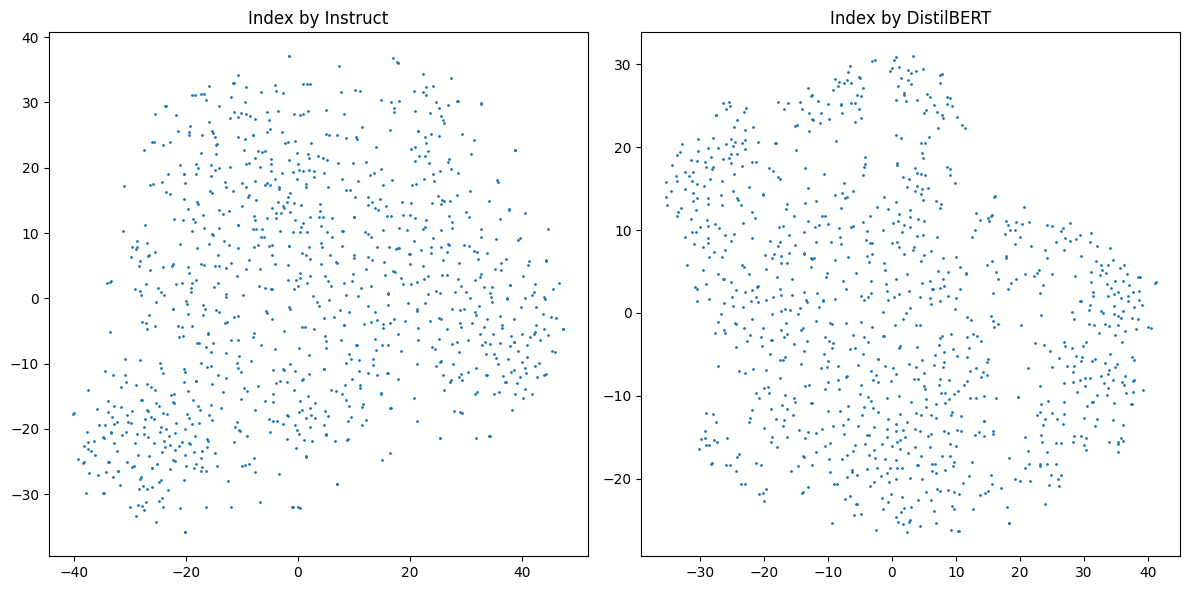

In [89]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def run_tsne(index, ax):
    # Retrieve the vectors from the FAISS index
    num_vectors = 1000  # assuming you have at least 1000 vectors in your index
    vecs = index.reconstruct_n(0, num_vectors)

    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    vecs_2d = tsne.fit_transform(vecs)

    # Plot the results
    ax.scatter(vecs_2d[:, 0], vecs_2d[:, 1], s=1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Run t-SNE for index_ins
run_tsne(index_ins, ax1)
ax1.set_title('Index by Instruct')

# Run t-SNE for index_bert
run_tsne(index_bert, ax2)
ax2.set_title('Index by DistilBERT')

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
